In [7]:
import pandas as pd
import numpy as np
import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Importing Data

In [17]:
def convert_datetime(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name]) 

def set_datetime_index(df):
    df.set_index("Date", inplace=True)
    df.set_index( pd.to_datetime(df.index), inplace= True)

def read_all_data(exchange, start_year, end_year):
    all_years = []
    for year in range(start_year, end_year + 1):
        all_years.append(pd.read_excel(f"raw data/{exchange}/{exchange}_{year}.xlsx",
                        parse_dates = [1],
                        thousands = ",",
                        na_values = ["-",""] ) )
    all_years = pd.concat(all_years)
    all_years.drop(columns = ["Unnamed: 0"], inplace = True)
    all_years.rename(columns = {"Lowest_Price": "High_Price", "Highest_Price": "Low_price"}, inplace = True)
    return all_years

In [19]:
# hose_all = read_all_data("HOSE", 2000, 2020)
# hnx_all = read_all_data("HASTC", 2005, 2020)

In [143]:
hose_all = pd.read_csv("HOSE_daily_trade.csv")
hnx_all = pd.read_csv("HNX_daily_trade.csv")
hnx_all.rename(columns = {'Close_Price': "Close",
       'Average_Price':"Avg", 'Reference_Price':"Adj_close", 'Open_Price':"Open", 'High_Price':"High",
       'Low_price':"Low"}, inplace=True)
hose_all.rename(columns = {'Close_Price': "Close",
       'Average_Price':"Avg", 'Reference_Price':"Adj_close", 'Open_Price':"Open", 'High_Price':"High",
       'Low_price':"Low"}, inplace=True)
convert_datetime(hose_all, "Date")
convert_datetime(hnx_all, "Date")

In [146]:
hose = pd.read_csv("cleaned data/VNINDEX_2000_2020.csv")
hnx = pd.read_csv("cleaned data/HNXINDEX_2005_2020.csv")

convert_datetime(hose, "Date")
convert_datetime(hnx, "Date")

In [52]:
hose_stocks_list = pd.read_csv("cleaned data/HOSE_Stocks.csv")
hnx_stocks_list = pd.read_csv("cleaned data/HNX_Stocks.csv")

hose_stocks_list.drop(columns = ["Unnamed: 0"], inplace = True)
hnx_stocks_list.drop(columns = ["Unnamed: 0"], inplace = True)

convert_datetime(hose_stocks_list, "IPO_Date")
convert_datetime(hnx_stocks_list, "IPO_Date")

hnx_stocks_list.fillna(value = {"Sector":"Unknown"}, inplace = True)
hose_stocks_list.fillna(value = {"Sector":"Unknown"}, inplace = True)

convert_datetime(hose_stocks_list, "Delisting_Date")
convert_datetime(hnx_stocks_list, "Delisting_Date")

# Visualizations

## Overview

In [51]:
def calc_moving_average(df, variable , periods = 20):
    return df[variable].rolling(window = periods).mean()

def calc_bollinger_band(df, variable, periods = 20):
    ma = calc_moving_average(df, variable, periods = 20)
    stdev = df[variable].rolling(window = periods).std(ddof = 0)
    up_band = ma + 2 * stdev
    low_band = ma - 2 * stdev
    return low_band, up_band

def calc_ewm(df, variable, span = 20):
    return df[variable].ewm(span = span).mean()

def plot_general(df, variable, name, periods = 20, ma = False, bol_band = False):

    low_band, up_band = calc_bollinger_band(df, variable, periods = 20)
    fig = go.Figure()
    
    if bol_band:
        fig.add_trace(go.Scatter(x=df.index, y=low_band,
                        fill=None,
                        mode='lines',
                        line_color= "#00CC96", 
                        name = "Bollinger's Lower Band"
                        ))
        fig.add_trace(go.Scatter(
                    x= df.index,
                    y= up_band,
                    fill='tonexty', # fill area between trace0 and trace1
                    mode='lines', 
                    line_color='#00CC96', 
                    name = "Bollinger's Upper Band"))
    if ma:
        df_ma = calc_moving_average(df, variable , periods )
        fig.add_trace(go.Scatter(x= df.index, y= df_ma,
                        mode='lines',
                        line_color = "indianred",
                        name= f'{periods}-day Moving Average'))
    fig.add_trace(go.Scatter( x=df.index, y=df[variable],
                            mode='lines',
                             line_color= "indigo",
                            name= name) )

    return fig


## Number of Listings by Sector

In [101]:
sectors = np.sort(np.unique(hnx_stocks_list["Sector"]))
sector_color_map = {}
for s in range(len(sectors)):
    sector_color_map[sectors[s]]= px.colors.qualitative.Light24[s]

In [102]:
def sum_sector_by_year(stocks_list, start_date):
    yearly_list = []
    for y in pd.date_range(start_date, "2020-12-31", freq = "Y" ):
        cond = stocks_list.apply(lambda row: row["IPO_Date"] <= y and ( (pd.isna(row["Delisting_Date"])) or row["Delisting_Date"] > y), axis=1)
        active = stocks_list[cond][["Sector","Symbol"]].groupby("Sector").size().reset_index(name='Count')
        active["Year"] = np.repeat(y.year, len(active))
        yearly_list.append(active)
    return pd.concat(yearly_list, ignore_index = True)

def plot_by_sector(stocks_list, start_date, ex):
    sector_count = sum_sector_by_year(stocks_list, start_date)
    fig = px.bar(sector_count, x="Year", y="Count", 
                            color = "Sector",
                            color_discrete_map = sector_color_map,
                            title=f"Number of Listings by Sector on {ex}")
    fig.show()

plot_by_sector(hnx_stocks_list, "2005-12-31", "HNX")

In [175]:
hose_sector_count = sum_sector_by_year(hose_stocks_list, "2000-12-31")
hnx_sector_count = sum_sector_by_year(hnx_stocks_list, "2005-12-31")
hose_sector_count["Exchange"] = np.repeat('HOSE', len(hose_sector_count))
hnx_sector_count["Exchange"] = np.repeat('HNX', len(hnx_sector_count))

sector_count = hnx_sector_count.append(hose_sector_count)

fig = px.bar(sector_count, x="Year", y="Count", 
                        color = "Sector", facet_col = 'Exchange',
                        #color_discrete_map = sector_color_map,
                        title=f"Number of Listings by Sector",
                        width=1200, height=800)
fig.show()

## Distribution of Stock Prices

In [ ]:
def compare_dist(df, ):


In [160]:
mean_df = hnx_all[["Date","Symbol", "Close"]].set_index("Date").groupby("Symbol").\
    resample("M").mean().reset_index()

Index(['Symbol', 'Date', 'Close'], dtype='object')

In [176]:
# import plotly.figure_factory as ff

# fig = px.histogram(hnx, x="Close", color=[i.year for i in hnx["Date"]], opacity=0.5)
# fig.show()

# hist_data = []
# group_labels = []
# for y in range(2015, 2021):
#     hist_data.append(hnx[[row.year == y for row in hnx["Date"] ]]["Close"] )
#     group_labels.append(y)

# fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
# fig.update_layout(title_text='Curve and Rug Plot')
# fig.show()

fig = go.Figure()


for y in range(2005, 2021):
    fig.add_trace(go.Box(x=  hnx[[row.year == y for row in hnx["Date"] ]]["Close"],
                            name= y,
                            #box_visible=True,
                            #meanline_visible=True
                            ))
fig.update_layout(width=800, height=500,
    title_text="Distribution of Stock prices on HNX by Year")
fig.show()

In [177]:
fig = go.Figure()


for y in range(2000, 2021):
    fig.add_trace(go.Box(x= hose[[row.year == y for row in hose["Date"] ]]["Close"],
                            name= y
                            #box_visible=True,
                            #meanline_visible=True
                            ))
fig.update_layout(width=800, height=500,
    title_text="Distribution of Stock prices on HOSE by Year")
fig.show()

## Time Trends

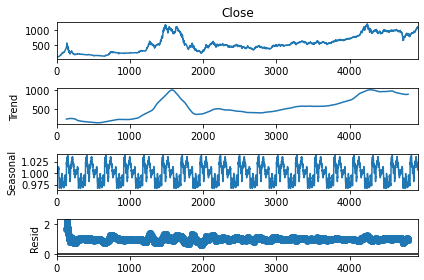

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose

hose_decomp = seasonal_decompose(hose["Close"], period = 365 - 52*2, model='multiplicative')
hose_decomp.plot()
plt.show()

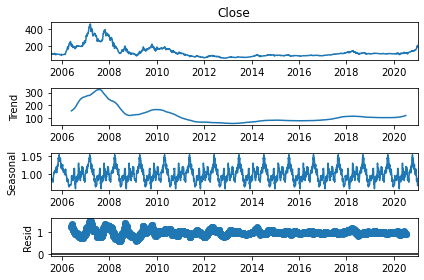

In [110]:
hnx_decomp = seasonal_decompose(hnx["Close"], period = 365 - 52*2, model='multiplicative')
hnx_decomp.plot()
plt.show()

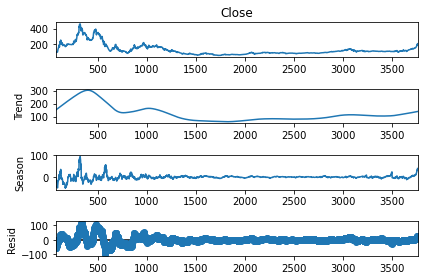

In [150]:
from statsmodels.tsa.seasonal import STL
hnx_decomp = STL(hnx[ [row.year >= 2006 for row in hnx["Date"]] ]["Close"], period = 365 - 52*2).fit()
hnx_decomp.plot()
plt.show()

In [135]:
hnx_decomp.resid

Date
2006-01-04   -47.103933
2006-01-06   -52.407575
2006-01-09   -49.929886
2006-01-11   -52.768146
2006-01-13   -53.409956
                ...    
2020-12-25    21.125456
2020-12-28    22.699250
2020-12-29    22.528149
2020-12-30    22.558485
2020-12-31    25.058350
Name: resid, Length: 3695, dtype: float64